In [2]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

# Read the jsonl file and convert it to a JSON list
def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

# Save the JSON list to a file
def save_as_json(json_list, output_file_path):
    if os.path.exists(output_file_path):
        return
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    if os.path.exists(output_file_path):
        return
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_accuracy(data):
    correct_predictions = 0
    total_predictions = len(data)
    for item in data:
        if 'predicted_answer' not in item:
            print(item['realidx'])
        if item['answer_idx'] == item['predicted_answer']:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if 'cost' in item:
            total_cost += item['cost']
        elif model == 'gpt-4o-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['completion_tokens'] * 4.0 / 1000000
        elif model == 'QwQ-32B-Preview':
            total_cost += item['token_usage']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['completion_tokens'] * 1.2 / 1000000
        elif model == 'DeepSeek-R1':
            total_cost += item['token_usage']['prompt_tokens'] * 7 / 1000000 + item['token_usage']['completion_tokens'] * 7 / 1000000
        elif model == 'DeepSeek-V3':
            total_cost += item['token_usage']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['completion_tokens'] * 1.25 / 1000000
        elif model == 'Llama-3.3-70B-Instruct-Turbo':
            total_cost += item['token_usage']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_elapsed']
    return total_time / len(data)

In [3]:
# Create test_hard.json with questions that have low accuracy across models
hard_questions = {}

models = [
    'gpt-4o-mini',
    'gpt-4o', 
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot']
tasks = ['medqa', 'pubmedqa', 'medmcqa', 'medbullets', 'mmlu', 'mmlu-pro', 'afrimedqa', 'medexqa', 'medxpertqa-r', 'medxpertqa-u']

hard_bands = {}
for task in tasks:
    # Track correct answers per question across all models
    question_correct_counts = {}
    question_total_counts = {}
    
    # First pass - count correct answers for each question
    for model in models:
        for method in methods:
            try:
                file_path = f'../output/{task}/{model}-{task}-test-{method}.json'
                data = load_json(file_path)
                dedup_data = deduplicate_data(data)

                for item in dedup_data:
                    question = item['realidx']
                    if question not in question_correct_counts:
                        question_correct_counts[question] = 0
                        question_total_counts[question] = 0

                    # Increment total count
                    question_total_counts[question] += 1
                    
                    # Check if answer was correct
                    if item['answer_idx'] == item['predicted_answer']:
                        question_correct_counts[question] += 1
                        
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    hard_questions_task = []
    file_path = f'../data/{task}/test.jsonl'
    data = load_jsonl(file_path)
    for problem in data:
        total_count = question_total_counts[problem['realidx']]
        correct_count = question_correct_counts[problem['realidx']]
        if correct_count / total_count < 0.5:  # Less than 5/10 correct
            hard_questions_task.append(problem)

    if len(hard_questions_task) > 100:
        hard_questions_task = hard_questions_task[:100]

    hard_correct_ratios = []
    for q in hard_questions_task:
        ratio = question_correct_counts[q['realidx']] / question_total_counts[q['realidx']]
        hard_correct_ratios.append(ratio)

    # Count hard questions in each correctness band
    hard_bands[task] = {
        "0/10": len([r for r in hard_correct_ratios if r < 0.1]),
        "1/10": len([r for r in hard_correct_ratios if 0.1 <= r < 0.2]), 
        "2/10": len([r for r in hard_correct_ratios if 0.2 <= r < 0.3]),
        "3/10": len([r for r in hard_correct_ratios if 0.3 <= r < 0.4]),
        "4/10": len([r for r in hard_correct_ratios if 0.4 <= r < 0.5]),
        "5/10": len([r for r in hard_correct_ratios if 0.5 <= r < 0.6]),
        "6/10": len([r for r in hard_correct_ratios if 0.6 <= r < 0.7]),
        "7/10": len([r for r in hard_correct_ratios if 0.7 <= r < 0.8]),
        "8/10": len([r for r in hard_correct_ratios if 0.8 <= r < 0.9]),
        "9/10": len([r for r in hard_correct_ratios if 0.9 <= r < 1.0]),
        "10/10": len([r for r in hard_correct_ratios if r >= 1.0])
    }

    if hard_questions_task:
        if task not in hard_questions:
            hard_questions[task] = {}
        hard_questions[task] = hard_questions_task
        
    save_as_jsonl(hard_questions[task], f'../data/{task}/test_hard.jsonl')

# Print summary table
summary_table = PrettyTable()
summary_table.field_names = ["Task", "Number of Hard Questions"]

for task in hard_questions:
    num_hard = len(hard_questions[task])
    summary_table.add_row([task, num_hard])

print("\nSummary of Hard Questions (correct < 50% across models):")
print(summary_table)



Summary of Hard Questions (correct < 50% across models):
+--------------+--------------------------+
|     Task     | Number of Hard Questions |
+--------------+--------------------------+
|    medqa     |           100            |
|   pubmedqa   |           100            |
|   medmcqa    |           100            |
|  medbullets  |            89            |
|     mmlu     |            73            |
|   mmlu-pro   |           100            |
|  afrimedqa   |            32            |
|   medexqa    |           100            |
| medxpertqa-r |           100            |
| medxpertqa-u |           100            |
+--------------+--------------------------+


Processing dataset 'medqa' with 10 model file(s).
Processing dataset 'medmcqa' with 10 model file(s).
Processing dataset 'pubmedqa' with 10 model file(s).
Processing dataset 'medbullets' with 10 model file(s).
Processing dataset 'mmlu-pro' with 10 model file(s).
Processing dataset 'mmlu' with 10 model file(s).
Processing dataset 'medexqa' with 10 model file(s).
Processing dataset 'medxpertqa-r' with 10 model file(s).
Processing dataset 'medxpertqa-u' with 10 model file(s).


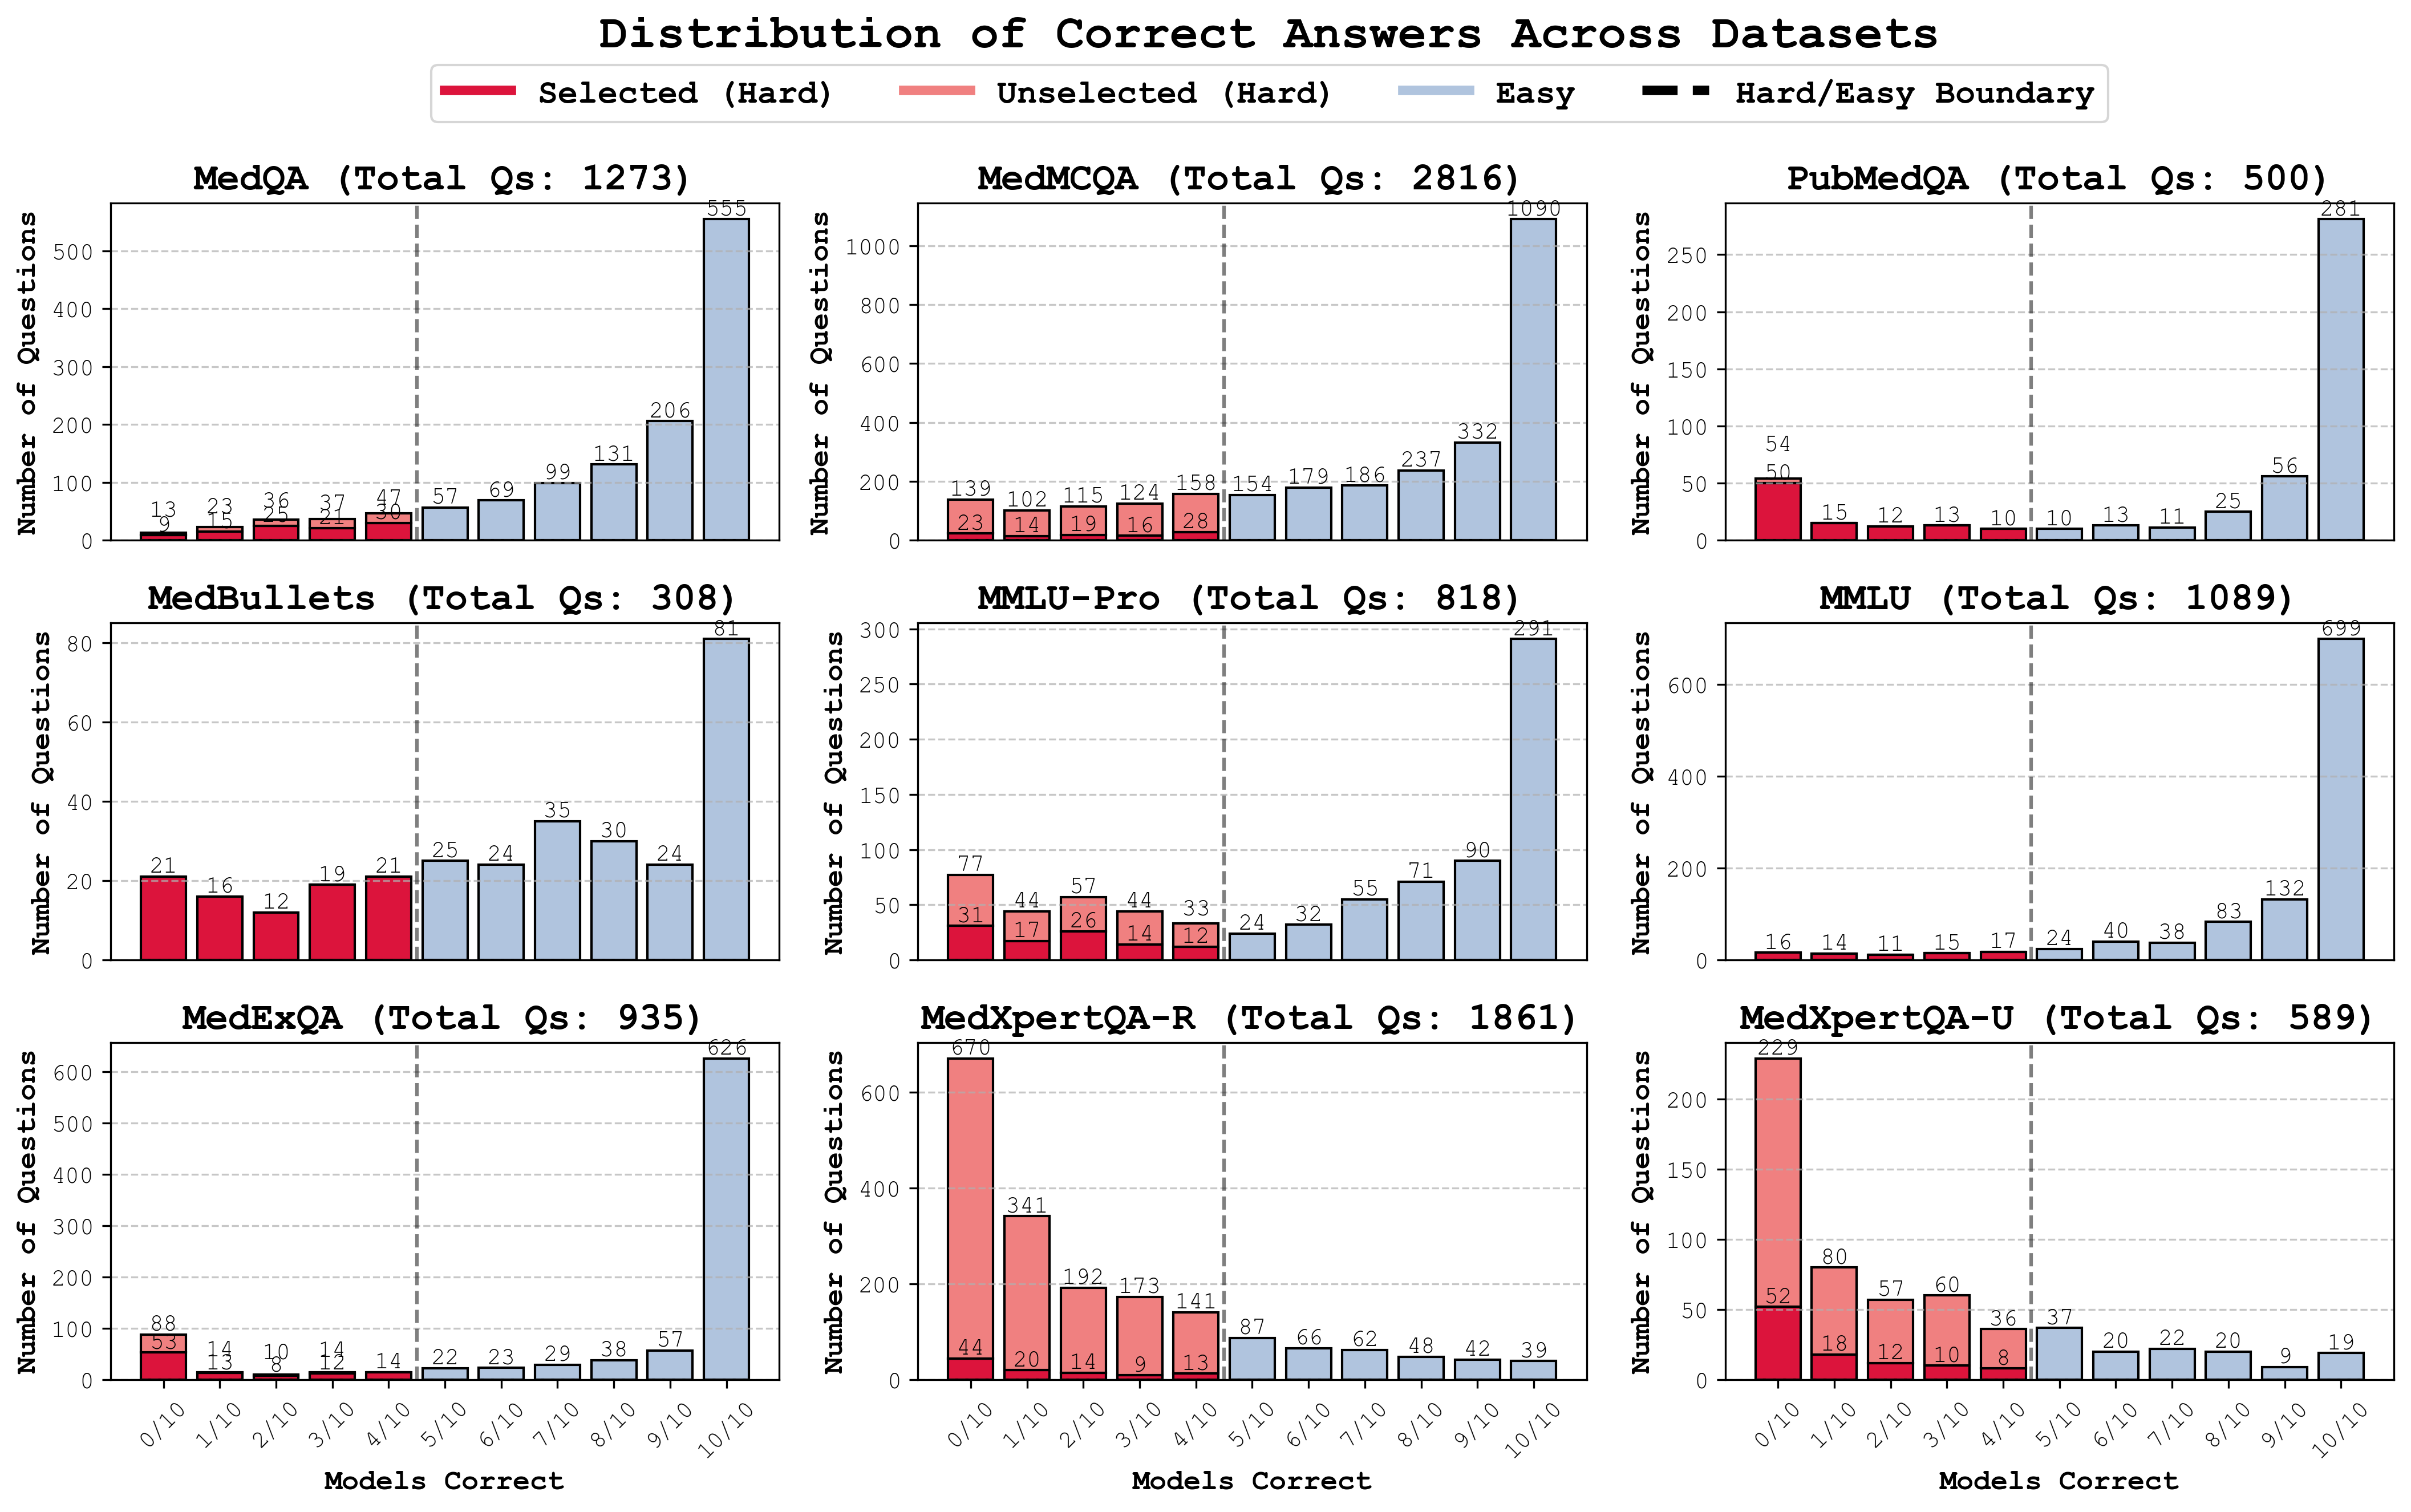

In [7]:
import os
import json
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from collections import Counter

# Set different font families for different elements
plt.rcParams['font.family'] = 'Courier New'  # Base font
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Custom font settings
title_font = {'family': 'Courier New', 'fontsize': 16, 'fontweight': 'bold'}
legend_font = {'family': 'Courier New', 'fontsize': 8, 'fontweight': 'bold'}
number_font = {'family': 'Courier New', 'fontsize': 10}
axis_font = {'family': 'Courier New', 'fontsize': 12, 'fontweight': 'bold'}

# Assume that both 'datasets' and 'model_names' are defined previously.
datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'medexqa', 'medxpertqa-r', 'medxpertqa-u']
dataset_map = {
    'medqa': 'MedQA',
    'pubmedqa': 'PubMedQA',
    'medmcqa': 'MedMCQA',
    'medbullets': 'MedBullets',
    'mmlu': 'MMLU',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfrimedQA',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfrimedQA',
    'medexqa': 'MedExQA',
    'medxpertqa-r': 'MedXpertQA-R',
    'medxpertqa-u': 'MedXpertQA-U'
}
# model_names is assumed to be defined earlier (e.g., model_names = ['claude-3-5-haiku', 'claude-3-5-sonnet', ...])

# Determine subplot grid dimensions (using 3 columns for a balanced layout)
n_datasets = len(datasets)
ncols = 3
nrows = math.ceil(n_datasets / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), dpi=300)
axes = axes.flatten()

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

for ax, dataset in zip(axes, datasets):
    print(f"Processing dataset '{dataset}' with {len(models)} model file(s).")
    
    # Aggregate the count of models that answered each question correctly.
    # Use the question's unique identifier ("realidx") if available; otherwise, fallback to "question" text.
    question_correct = {}  # key: question identifier; value: count of correct responses across models
    
    for model in models:
        # Convert model name to a file-friendly format.
        model_filename = model.replace('/', '_')
        # Construct the expected JSON filename.
        file_path = os.path.join('..', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}' with expected filename: {file_path}")
            continue
        
        with open(file_path, 'r') as f:
            try:
                predictions = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue
        
        for entry in predictions:
            # Use "realidx" as unique identifier if provided; otherwise, fallback to the "question" text.
            qid = entry.get("realidx") or entry.get("question", "unknown_question")
            # Determine whether the model's answer is correct.
            predicted = str(entry.get("predicted_answer", "")).strip()
            correct_ans = str(entry.get("answer_idx", "")).strip()
            # Initialize count for this question if not already present.
            if qid not in question_correct:
                question_correct[qid] = 0
            if predicted == correct_ans:
                question_correct[qid] += 1

    # Assume the total number of models equals the length of model_names.
    total_models = len(models)
    
    # Compute the distribution: count how many questions received k correct answers (k = 0, 1, ..., total_models).
    distribution = Counter(question_correct.values())
    
    # Prepare data for plotting: ensure counts for all possible correct responses are present.
    x_values = list(range(total_models + 1))
    y_counts = [distribution.get(k, 0) for k in x_values]
    y_counts_selected = [hard_bands[dataset][f"{k}/{total_models}"] for k in x_values]
    y_counts_unselected = [y_counts[i] - y_counts_selected[i] for i in range(len(x_values))]
    x_labels = [f"{k}/{total_models}" for k in x_values]

    # Create a stacked bar plot in the corresponding subplot axis, stacking the 'selected' and 'unselected' counts.
    colors_selected = ['crimson' if k/total_models < 0.5 else 'skyblue' for k in x_values]
    # Use a lighter shade for the unselected portion.
    colors_unselected = ['lightcoral' if k/total_models < 0.5 else 'lightsteelblue' for k in x_values]
    selected_bars = ax.bar(x_values, y_counts_selected, color=colors_selected, edgecolor='black', label='Selected')
    unselected_bars = ax.bar(x_values, y_counts_unselected, bottom=y_counts_selected, color=colors_unselected, edgecolor='black', label='Unselected')
    
    # Add vertical dashed line at x = total_models/2 to separate hard and easy regions
    ax.axvline(x=(total_models - 1)/2, color='black', linestyle='--', alpha=0.5)
    
    # Only add x-axis label to the bottom row
    if ax in axes[-ncols:]:
        ax.set_xlabel("Models Correct", fontdict=axis_font)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_labels, rotation=45, fontdict=number_font)
    else:
        ax.set_xticks([])
    
    ax.set_ylabel("Number of Questions", fontdict=axis_font)
    ax.set_title(f"{dataset_map[dataset]} (Total Qs: {sum(y_counts)})", fontdict=title_font)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate each bar with its count value for added clarity.
    for ubar, sbar in zip(unselected_bars, selected_bars):
        uheight = ubar.get_height()
        sheight = sbar.get_height()
        if uheight > 0:
            ax.text(ubar.get_x() + ubar.get_width() / 2, max(uheight, 25 if sheight > 0 else 0) + sheight, f'{int(uheight) + int(sheight)}', 
                   ha='center', va='bottom', fontdict=number_font)
        if sheight > 0:
            ax.text(sbar.get_x() + sbar.get_width() / 2, sheight, f'{int(sheight)}', 
                   ha='center', va='bottom', fontdict=number_font)

# Hide any unused subplots.
for ax in axes[n_datasets:]:
    ax.axis('off')

# Add a single legend for all subplots
legend_elements = [
    Line2D([0], [0], color='crimson', lw=4, label='Selected (Hard)'),
    Line2D([0], [0], color='lightcoral', lw=4, label='Unselected (Hard)'),
    Line2D([0], [0], color='lightsteelblue', lw=4, label='Easy'),
    Line2D([0], [0], color='black', linestyle='--', lw=4, label='Hard/Easy Boundary')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.93), ncol=4, prop={'size': 14, 'weight': 'bold'})

fig.suptitle("Distribution of Correct Answers Across Datasets", weight='bold', fontsize=20)
fig.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for legend
plt.savefig('../assets/hardset.png')
plt.savefig('../assets/hardset.pdf')
plt.show()